# **Data Augmentation For Brain Tumor Segmentation Using MONAI Framework**


In [ ]:
from google.colab import drive, files, data_table
MOUNT_PATH = "/content/gdrive"
drive.mount(MOUNT_PATH)

# Disabling by default the DataTable representation of DataFrame in Google Colab
data_table.disable_dataframe_formatter()

Mounted at /content/gdrive


In [ ]:
%%bash
RED_COLOR='\033[0;31m'
NO_COLOR='\033[0m'
pkg_name=tree
dpkg -s $pkg_name &> /dev/null # Searching for tree package in the set of installed packages in Ubuntu.
if [ "$?" -ne "0" ]
    then
    echo -e "Installing tree package ..."
    apt-get autoclean && apt-get autoremove && apt-get install $pkg_name
    if [ "$?" -eq "0" ]
        then
        echo -e $RED_COLOR"tree package installed successfully\n"${NO_COLOR}
    fi
else
    echo -e "tree package already installed in the current runtime\n"
fi

Installing tree package ...
Reading package lists...
Building dependency tree...
Reading state information...
Reading package lists...
Building dependency tree...
Reading state information...
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
Reading package lists...
Building dependency tree...
Reading state information...
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 37 not upgraded.
Need to get 40.7 kB of archives.
After this operation, 105 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tree amd64 1.7.0-5 [40.7 kB]
Fetched 40.7 kB in 1s (48.9 kB/s)
Selecting previously unselected package tree.
(Reading database ... 155222 files and directories currently installed.)
Preparing to unpack .../tree_1.7.0-5_amd64.deb ...
Unpacking tree (1.7.0-5) ...
Setting up tree (1.7.0-5) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
tree package installed successfully



In [ ]:
!lsb_release -a
print()
!nvcc --version
print()
!nvidia-smi

No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 18.04.5 LTS
Release:	18.04
Codename:	bionic

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0

Fri Dec 31 08:46:44 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A 

In [ ]:
%%bash
python3 -m pip install --upgrade -r "/content/gdrive/MyDrive/Brain-Tumor-Segmentation-Minor-Project/requirement.txt"

  Attempting uninstall: nibabel
    Found existing installation: nibabel 3.0.2
    Uninstalling nibabel-3.0.2:
      Successfully uninstalled nibabel-3.0.2
  Attempting uninstall: plotly
    Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1


In [ ]:
import os
import sys
import glob
import random

import warnings
warnings.filterwarnings("ignore", category = FutureWarning)

import numpy as np
import pandas as pd

# Libraries to process nii.gz files
import nibabel as nib

# Libraries for Data Visualisation and Image Processing
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use("ggplot")
mpl.rcParams["figure.dpi"] = 300
%matplotlib inline
import missingno as msno
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from PIL import Image, ImageEnhance

import torch
from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard

import monai
from monai.data import (Dataset, 
                        DataLoader)
from monai.transforms import *
from monai.visualize import (add_animated_gif, 
                             plot_2d_or_3d_image)
from monai.utils import set_determinism

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Conv3D, MaxPool3D, AvgPool3D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import *

In [ ]:
%%bash
python3 -c "import sklearn as skt; print(f'Version of scikit-learn: {skt.__version__}')"
python3 -c "import tensorflow as tf; print(f'Version of Tensorflow: {tf.__version__}')"
python3 -c "import torch; print(f'Version of PyTorch: {torch.__version__}')"
python3 -c "import monai; monai.config.print_config()"

Version of scikit-learn: 1.0.1
Version of Tensorflow: 2.7.0
Version of PyTorch: 1.10.0+cu111
MONAI version: 0.8.0
Numpy version: 1.19.5
Pytorch version: 1.10.0+cu111
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 714d00dffe6653e21260160666c4c201ab66511b

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.2.1
scikit-image version: 0.18.3
Pillow version: 7.1.2
Tensorboard version: 2.7.0
gdown version: 3.6.4
TorchVision version: 0.11.1+cu111
tqdm version: 4.62.3
lmdb version: 0.99
psutil version: 5.4.8
pandas version: 1.1.5
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [ ]:
PROJECT_ROOT = os.path.abspath("gdrive/MyDrive/Brain-Tumor-Segmentation-Minor-Project")
DATASET_PATH = os.path.join(PROJECT_ROOT, "Datasets")
TENSORBOARD_VIZ_PATH = os.path.join(PROJECT_ROOT, "Visualizations")
MODEL_CHECKPOINT_PATH = os.path.join(PROJECT_ROOT, "Model-Checkpoints")
SHOW_TENSORBOARD = False # Boolean created to toggle the display of tensorboard
VIEW_DATA_TABLE = False # Boolean created to toggle the display of DataTable version of DataFrames

BRATS_2020_TRAINING_DATA_PATH = os.path.join(DATASET_PATH, "BRATS-2020", "Training-Data")
BRATS_2020_VALIDATION_DATA_PATH = os.path.join(DATASET_PATH, "BRATS-2020", "Validation-Data")

training_name_mapping_csv_path = os.path.join(BRATS_2020_TRAINING_DATA_PATH, "name_mapping.csv")
training_survival_csv_path = os.path.join(BRATS_2020_TRAINING_DATA_PATH, "survival_info.csv")

validation_name_mapping_csv_path = os.path.join(BRATS_2020_VALIDATION_DATA_PATH, "name_mapping_validation_data.csv")
validation_survival_csv_path = os.path.join(BRATS_2020_VALIDATION_DATA_PATH, "survival_evaluation.csv")

try:
    assert os.path.isdir(PROJECT_ROOT) 
    assert os.path.isdir(DATASET_PATH) 
    assert os.path.isdir(BRATS_2020_TRAINING_DATA_PATH) 
    assert os.path.isdir(BRATS_2020_VALIDATION_DATA_PATH)
    assert os.path.isdir(TENSORBOARD_VIZ_PATH)
    assert os.path.isdir(MODEL_CHECKPOINT_PATH)
except AssertionError as ae:
    raise Exception("Assertion Error: Invalid Directory Path")

try:
    assert os.path.isfile(training_name_mapping_csv_path) 
    assert os.path.isfile(training_survival_csv_path) 
    assert os.path.isfile(validation_name_mapping_csv_path) 
    assert os.path.isfile(validation_survival_csv_path)
except AssertionError as ae:
    raise Exception("Assertion Error: Invaid File Path")

In [ ]:
RANDOM_SEED_VALUE = 42
random.seed(RANDOM_SEED_VALUE)
set_determinism(seed = RANDOM_SEED_VALUE)

# We are dealing with four structural MRI sequences i.e. T1, T1w-Gd, T2, T2-FLAIR
TOTAL_BRAIN_MRI_REPRESENTATION = 4 
# We are having three classes to which the segmentation maps belong to i.e. Whole Tumor (WT), Tumor Core (TC), Enhancing Tumor (ET)
TOTAL_SEGMENTATION_MAPS = 3

# Check wether CUDA is available or not.
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
hgg_colors = ["White", "Blue", "Yellow", "Red"]
hgg_cmap = mpl.colors.ListedColormap(hgg_colors)
hgg_norm = mpl.colors.BoundaryNorm([0, 0.9, 1.9, 3.9, 4.9], hgg_cmap.N)

lgg_colors = ["White", "Blue", "Yellow"]
lgg_cmap = mpl.colors.ListedColormap(lgg_colors)
lgg_norm = mpl.colors.BoundaryNorm([0, 0.9, 1.9, 2.9], lgg_cmap.N)

In [ ]:
!tree -d -p -h -C $BRATS_2020_TRAINING_DATA_PATH

/content/gdrive/MyDrive/Brain-Tumor-Segmentation-Minor-Project/Datasets/BRATS-2020/Training-Data
├── [drwx------ 4.0K]  BraTS20_Training_001
├── [drwx------ 4.0K]  BraTS20_Training_002
├── [drwx------ 4.0K]  BraTS20_Training_003
├── [drwx------ 4.0K]  BraTS20_Training_004
├── [drwx------ 4.0K]  BraTS20_Training_005
├── [drwx------ 4.0K]  BraTS20_Training_006
├── [drwx------ 4.0K]  BraTS20_Training_007
├── [drwx------ 4.0K]  BraTS20_Training_008
├── [drwx------ 4.0K]  BraTS20_Training_009
├── [drwx------ 4.0K]  BraTS20_Training_010
├── [drwx------ 4.0K]  BraTS20_Training_011
├── [drwx------ 4.0K]  BraTS20_Training_012
├── [drwx------ 4.0K]  BraTS20_Training_013
├── [drwx------ 4.0K]  BraTS20_Training_014
├── [drwx------ 4.0K]  BraTS20_Training_015
├── [drwx------ 4.0K]  BraTS20_Training_016
├── [drwx------ 4.0K]  BraTS20_Training_017
├── [drwx------ 4.0K]  BraTS20_Training_018
├── [drwx------ 4.0K]  BraTS20_Training_019
├── [drwx------ 4.0K]  BraTS20_Training_020
├── [drwx------ 4.0K]  

In [ ]:
!tree -d -p -h -C $BRATS_2020_VALIDATION_DATA_PATH

/content/gdrive/MyDrive/Brain-Tumor-Segmentation-Minor-Project/Datasets/BRATS-2020/Validation-Data
├── [drwx------ 4.0K]  BraTS20_Validation_001
├── [drwx------ 4.0K]  BraTS20_Validation_002
├── [drwx------ 4.0K]  BraTS20_Validation_003
├── [drwx------ 4.0K]  BraTS20_Validation_004
├── [drwx------ 4.0K]  BraTS20_Validation_005
├── [drwx------ 4.0K]  BraTS20_Validation_006
├── [drwx------ 4.0K]  BraTS20_Validation_007
├── [drwx------ 4.0K]  BraTS20_Validation_008
├── [drwx------ 4.0K]  BraTS20_Validation_009
├── [drwx------ 4.0K]  BraTS20_Validation_010
├── [drwx------ 4.0K]  BraTS20_Validation_011
├── [drwx------ 4.0K]  BraTS20_Validation_012
├── [drwx------ 4.0K]  BraTS20_Validation_013
├── [drwx------ 4.0K]  BraTS20_Validation_014
├── [drwx------ 4.0K]  BraTS20_Validation_015
├── [drwx------ 4.0K]  BraTS20_Validation_016
├── [drwx------ 4.0K]  BraTS20_Validation_017
├── [drwx------ 4.0K]  BraTS20_Validation_018
├── [drwx------ 4.0K]  BraTS20_Validation_019
├── [drwx------ 4.0K]  BraT

In [ ]:
training_mapping_df = pd.read_csv(training_name_mapping_csv_path)
validation_mapping_df = pd.read_csv(validation_name_mapping_csv_path)

In [ ]:
training_mapping_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 369 entries, 0 to 368
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Grade                  369 non-null    object
 1   BraTS_2017_subject_ID  285 non-null    object
 2   BraTS_2018_subject_ID  285 non-null    object
 3   TCGA_TCIA_subject_ID   167 non-null    object
 4   BraTS_2019_subject_ID  335 non-null    object
 5   BraTS_2020_subject_ID  369 non-null    object
dtypes: object(6)
memory usage: 17.4+ KB


In [ ]:
training_mapping_df.head()

Grade BraTS_2017_subject_ID  ... BraTS_2019_subject_ID BraTS_2020_subject_ID
0   HGG   Brats17_CBICA_AAB_1  ...   BraTS19_CBICA_AAB_1  BraTS20_Training_001
1   HGG   Brats17_CBICA_AAG_1  ...   BraTS19_CBICA_AAG_1  BraTS20_Training_002
2   HGG   Brats17_CBICA_AAL_1  ...   BraTS19_CBICA_AAL_1  BraTS20_Training_003
3   HGG   Brats17_CBICA_AAP_1  ...   BraTS19_CBICA_AAP_1  BraTS20_Training_004
4   HGG   Brats17_CBICA_ABB_1  ...   BraTS19_CBICA_ABB_1  BraTS20_Training_005

[5 rows x 6 columns]

In [ ]:
if VIEW_DATA_TABLE:
    data_table.DataTable(training_mapping_df, include_index = False, num_rows_per_page = 10)

In [ ]:
glioma_type_count = training_mapping_df["Grade"].value_counts()[: :-1]
glioma_type_count

LGG     76
HGG    293
Name: Grade, dtype: int64

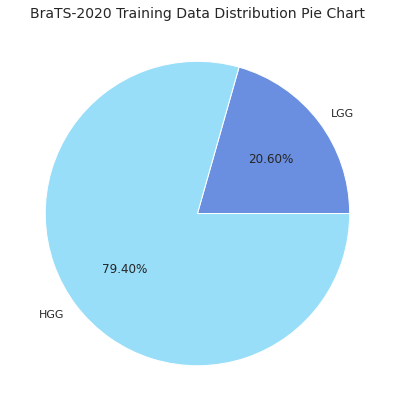

In [ ]:
sns.set(style = "whitegrid", color_codes = True)
fig, axis = plt.subplots(figsize = (10, 7))
axis.pie(x = glioma_type_count, labels = glioma_type_count.index, autopct = "%1.2f%%", colors = ["#6a8fe0", "#99def9"])
axis.set_title("BraTS-2020 Training Data Distribution Pie Chart", fontdict = dict(size = 14))
sns.despine()

In [ ]:
training_data_distribution_plot = px.bar(x = glioma_type_count.index, 
                                         y = glioma_type_count,
                                         labels = dict(x = "Observation Count", y = "Type of Glioma"),
                                         text = glioma_type_count,
                                         title = "BraTS-2020 Training Data Distribution",
                                         template = "gridon")
training_data_distribution_plot.update_traces(width = [0.1, 0.1], 
                                              marker_color = ["rgb(16, 118, 255)", "rgb(55, 83, 109)"],
                                              texttemplate = "%{text: .2s}", 
                                              textposition = "outside", 
                                              hovertemplate = None, 
                                              hoverinfo = "skip")
training_data_distribution_plot.update_layout(uniformtext = dict(minsize = 12),
                                              xaxis = dict(tickvals = ["LGG", "HGG"], 
                                                           ticktext = ["Low Grade Glioma (LGG)", "High Grade Glioma (HGG)"]),
                                              yaxis = dict(tickcolor = "white", 
                                                           ticklen = 10), # Hack so that y-axis line doesn't overlap with y-axis tick-labels.
                                              showlegend = False)
training_data_distribution_plot.show()

In [ ]:
validation_mapping_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   BraTS_2017_subject_ID  101 non-null    object
 1   BraTS_2018_subject_ID  118 non-null    object
 2   TCGA_TCIA_subject_ID   76 non-null     object
 3   BraTS_2019_subject_ID  125 non-null    object
 4   BraTS_2020_subject_ID  125 non-null    object
dtypes: object(5)
memory usage: 5.0+ KB


In [ ]:
validation_mapping_df.head()

BraTS_2017_subject_ID  ...   BraTS_2020_subject_ID
0   Brats17_CBICA_AAM_1  ...  BraTS20_Validation_001
1   Brats17_CBICA_ABT_1  ...  BraTS20_Validation_002
2   Brats17_CBICA_ALA_1  ...  BraTS20_Validation_003
3   Brats17_CBICA_ALT_1  ...  BraTS20_Validation_004
4   Brats17_CBICA_ALV_1  ...  BraTS20_Validation_005

[5 rows x 5 columns]

In [ ]:
if VIEW_DATA_TABLE:
    data_table.DataTable(validation_mapping_df, include_index = False, num_rows_per_page = 10)

In [ ]:
brats_2020_subject_ids = training_mapping_df["BraTS_2020_subject_ID"]
brats_2020_subject_ids.head()

0    BraTS20_Training_001
1    BraTS20_Training_002
2    BraTS20_Training_003
3    BraTS20_Training_004
4    BraTS20_Training_005
Name: BraTS_2020_subject_ID, dtype: object

In [ ]:
%%time
training_data_df = pd.DataFrame()

for curr_id, curr_grade in training_mapping_df[["BraTS_2020_subject_ID", "Grade"]].itertuples(index = False):
    absolute_path = os.path.join(BRATS_2020_TRAINING_DATA_PATH, curr_id)
    for curr_path, _, filenames in os.walk(absolute_path):
        training_data_df = training_data_df.append([(curr_id, os.path.join(curr_path, curr_file), curr_grade) for curr_file in filenames], ignore_index = True)

training_data_df.columns = ["brats_2020_id", "image_path", "tumor_class"]

CPU times: user 578 ms, sys: 53.3 ms, total: 632 ms
Wall time: 991 ms


In [ ]:
training_data_seg_masks_df = training_data_df.loc[training_data_df.image_path.str.contains("seg.nii.gz")]
training_data_df = training_data_df.drop(training_data_seg_masks_df.index).reset_index(drop = True)
training_data_seg_masks_df.reset_index(drop = True, inplace = True)

In [ ]:
training_data_df.head()

brats_2020_id  ... tumor_class
0  BraTS20_Training_001  ...         HGG
1  BraTS20_Training_001  ...         HGG
2  BraTS20_Training_001  ...         HGG
3  BraTS20_Training_001  ...         HGG
4  BraTS20_Training_002  ...         HGG

[5 rows x 3 columns]

In [ ]:
training_data_seg_masks_df.head()

brats_2020_id  ... tumor_class
0  BraTS20_Training_001  ...         HGG
1  BraTS20_Training_002  ...         HGG
2  BraTS20_Training_003  ...         HGG
3  BraTS20_Training_004  ...         HGG
4  BraTS20_Training_005  ...         HGG

[5 rows x 3 columns]

In [ ]:
print(f"""Total Observation In Training Dataset: {training_data_df.shape[0]}.
Total Observations In Training Data Segmentation Masks: {training_data_seg_masks_df.shape[0]}.""")

Total Observation In Training Dataset: 1476.
Total Observations In Training Data Segmentation Masks: 369.


In [ ]:
example_hgg_mri_image_path = training_data_df.image_path[0]
example_hgg_mri_image_seg_mask_path = training_data_seg_masks_df.image_path[0]

example_lgg_mri_image_path = training_data_df.image_path[1040]
example_lgg_mri_image_seg_mask_path = training_data_seg_masks_df.image_path[261]

In [ ]:
example_hgg_mri_image = nib.load(example_hgg_mri_image_path).get_fdata()
example_hgg_mri_seg_mask_image = nib.load(example_hgg_mri_image_seg_mask_path).get_fdata()

example_lgg_mri_image = nib.load(example_lgg_mri_image_path).get_fdata()
example_lgg_mri_seg_mask_image = nib.load(example_lgg_mri_image_seg_mask_path).get_fdata()

In [ ]:
print("Information About High Grade Glioma (HGG) Cases Data:")
print(f"\tDimension of Structural Brain MRI Sequence (T1, T1-Gd, T2, T2-FLAIR): {example_hgg_mri_image.shape}")
print(f"\tDimension of Structural Brain MRI Segmentation Map: {example_hgg_mri_seg_mask_image.shape}", end = "\n\n")

print("Information About Low Grade Glioma (LGG) Cases Data:")
print(f"\tDimension of Structural Brain MRI Sequence (T1, T1-Gd, T2, T2-FLAIR): {example_lgg_mri_image.shape}")
print(f"\tDimension of Structural Brain MRI Segmentation Map: {example_lgg_mri_seg_mask_image.shape}")

Information About High Grade Glioma (HGG) Cases Data:
	Dimension of Structural Brain MRI Sequence (T1, T1-Gd, T2, T2-FLAIR): (240, 240, 155)
	Dimension of Structural Brain MRI Segmentation Map: (240, 240, 155)

Information About Low Grade Glioma (LGG) Cases Data:
	Dimension of Structural Brain MRI Sequence (T1, T1-Gd, T2, T2-FLAIR): (240, 240, 155)
	Dimension of Structural Brain MRI Segmentation Map: (240, 240, 155)


In [ ]:
"""
Function is responsible for rendering the different representaion of Brain MRI Images i.e. T1, T1w-CE, T2, FLAIR from nii.gz files.
"""
def visualize_brain_mri_representations(mri_representation_paths: pd.Series, slice_index: int, glioma_grade: str) -> None:
    assert slice_index >= 0 and slice_index <= 155
    subplot_titles = [os.path.splitext(os.path.splitext(os.path.split(curr_path)[-1])[0])[0].split("_")[-1].strip().upper() for curr_path in mri_representation_paths]
    fig, axes = plt.subplots(ncols = 4, figsize = (20, 5))
    fig.suptitle("Brain MRI Representations (BraTS-2020)", fontdict = dict(size = 14))
    for curr_axis, curr_title, curr_path in zip(axes, subplot_titles, mri_representation_paths):
        curr_representation = CropForeground()(AsChannelFirst()(nib.load(curr_path).get_fdata().astype(np.float32) / 255.0))[slice_index]
        curr_axis.imshow(curr_representation, cmap = "gray", interpolation = "lanczos")
        curr_axis.set_title(curr_title, fontdict = dict(size = 12))
        # curr_axis.axis("off")

In [ ]:
"""
Function is responsible for rendering one of the representation of Brain MRI image and its segmentation mask.
"""
def visualise_brain_mri_seg(path_to_image: str, path_to_seg_mask: str, slice_index: int, glioma_grade: str) -> None:
    assert slice_index >= 0 and slice_index <= 155
    img_cmap, img_norm = (hgg_cmap, hgg_norm) if "HGG" in glioma_grade else (lgg_cmap, lgg_norm)
    fig, axes = plt.subplots(ncols = 3, figsize = (15, 7))
    fig.suptitle(f"Brain MRI Sequence & Segmentation Mask Visualization of {glioma_grade}", fontdict = dict(size = 16))
    
    brain_mri_slice = (nib.load(path_to_image).get_fdata().astype(np.float32) / 255.0).T[slice_index]
    axes[1].imshow(brain_mri_slice, cmap = "gray", interpolation = "nearest")
    axes[1].set_title("Slice of Brain MRI Sequence", fontdict = dict(size = 12))
    
    brain_mri_seg_slice = (nib.load(path_to_seg_mask).get_fdata().astype(np.int8)).T[slice_index]
    axes[2].imshow(brain_mri_seg_slice, cmap = img_cmap, norm = img_norm, interpolation = "bilinear")
    axes[2].set_title("Different Segmentation Masks", fontdict = dict(size = 12))
    axes[0].set_title("Brain MRI Slice With Segmentation Mask", fontdict = dict(size = 12))
    axes[0].imshow(brain_mri_slice, cmap = "gray", interpolation = "nearest")
    
    """
    Converting the ndarray dtype to np.float32 so that we can replace 0.0 with np.nan and then render the segmentation masks 
    because once 0.0s are replaced with np.nan the imshow method is not going to render the cells of the ndarray which are NaN values.
    """
    brain_mri_seg_slice = brain_mri_seg_slice.astype(np.float32)
    brain_mri_seg_slice[brain_mri_seg_slice == 0.0] = np.nan
    axes[0].imshow(brain_mri_seg_slice, cmap = img_cmap, norm = img_norm, interpolation = "bilinear", alpha = 0.7)
    axes[0].axis("off")
    sns.despine()
    fig.tight_layout()

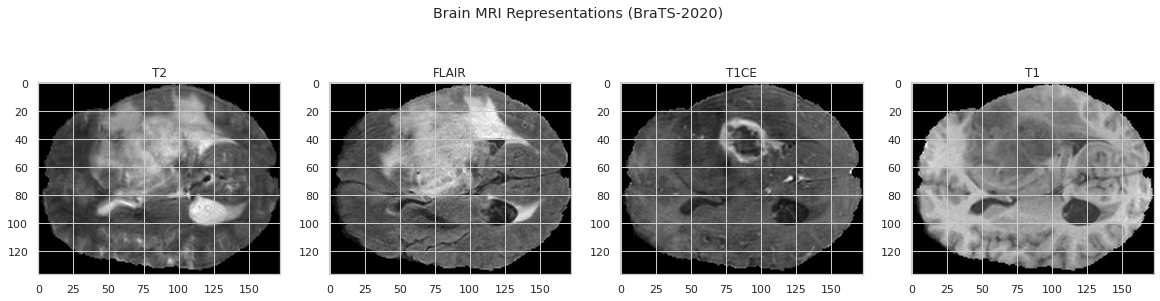

In [ ]:
visualize_brain_mri_representations(training_data_df.image_path[:4], 73, "HGG")

## **Details About Segmentation Masks**
* The expert annotated segmentation masks provided in the BraTS-2020 dataset consists of three segmentations:

Sr. No | Segmentation Mask | Segmentation Mask Label| Color Code (Refer Visualisation)|
:-------:|:-------------------:|:-----------:|:------------:|
1        | Necrotic and Non Enhancing Tumor (NCR/NET) | 1 | Blue |  
2        | Enhancing Tumor (ET)| 4| Red |
3        | Peritumoral Edematous Tissue (ED) | 2 | Yellow |
4        | Background | 0 | White |

NOTE: Color choices is according to `viridis` color map in `matplotlib` library.

*  The **whole tumor (WT)** class includes all visible labels or segmentation masks (a union of blue (1), yellow (4) and tuquoise (2) labels), 
* The **tumor core (TC)** class is a union of blue (1) and yellow (4), and 
* The **enhancing tumor core (ET)** class is shown in yellow (4) (a hyperactive tumor part).

In [ ]:
with SummaryWriter(log_dir = os.path.join(TENSORBOARD_VIZ_PATH, "HGG")) as curr_writer:
    add_animated_gif(curr_writer, 
                     tag = "High-Grade-Glioma MRI Scan",
                     image_tensor = np.expand_dims(example_hgg_mri_image, 0), 
                     max_out = 1, 
                     scale_factor = 255)
    add_animated_gif(curr_writer,
                     tag = "High-Grade-Glioma-Segmentation-Mask",
                     image_tensor = np.expand_dims(example_hgg_mri_seg_mask_image, 0),
                     max_out = 1,
                     scale_factor = 255)

In [ ]:
if SHOW_TENSORBOARD:
    %tensorboard --bind_all --logdir = $TENSORBOARD_VIZ_PATH/HGG

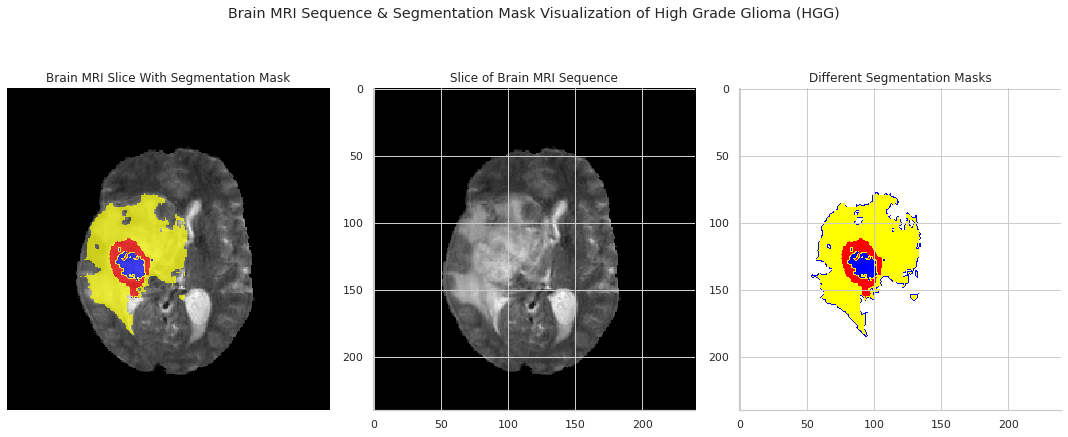

In [ ]:
visualise_brain_mri_seg(example_hgg_mri_image_path, example_hgg_mri_image_seg_mask_path, 73, "High Grade Glioma (HGG)")

In [ ]:
with SummaryWriter(log_dir = os.path.join(TENSORBOARD_VIZ_PATH, "LGG")) as curr_writer:
    add_animated_gif(curr_writer, 
                     tag = "Low-Grade-Glioma MRI Scan", 
                     image_tensor = np.expand_dims(example_lgg_mri_image, 0), 
                     max_out = 1, 
                     scale_factor = 255.0)
    add_animated_gif(curr_writer,
                     tag = "Low-Grade-Glioma-Segmentation-Map",
                     image_tensor = np.expand_dims(example_lgg_mri_seg_mask_image, 0), 
                     max_out = 1, 
                     scale_factor = 255.0)

In [ ]:
if SHOW_TENSORBOARD:
    %tensorboard --bind_all --logdir = $TENSORBOARD_VIZ_PATH/LGG

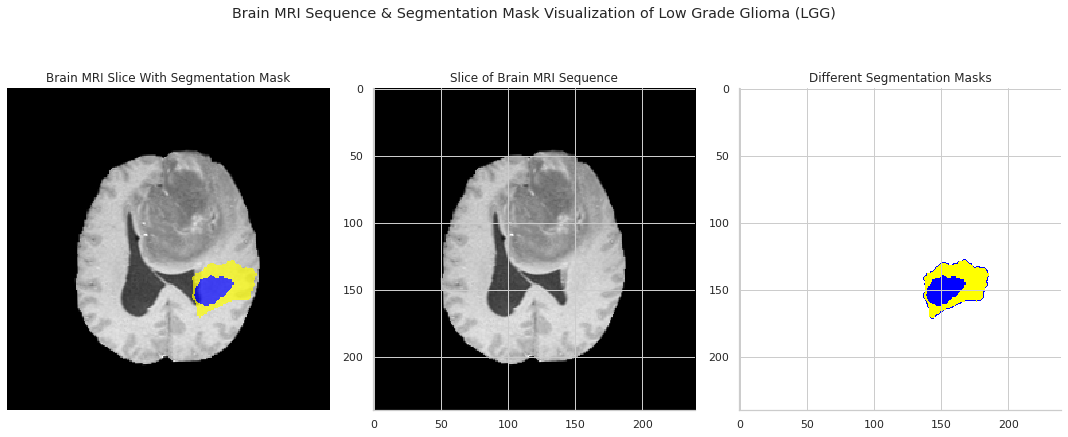

In [ ]:
visualise_brain_mri_seg(example_lgg_mri_image_path, example_lgg_mri_image_seg_mask_path, 90, "Low Grade Glioma (LGG)")

## **Data Augmentation Pipeline**

* Data Augmentation is a process which helps in solving the problem of overfitting which the deep neural network model is exposed to during the training process by increasing the size of the training dataset artificially by generating various different valid permutations of observations in the training dataset.

* We will be using the MONAI (Medical Open Network For AI) domain specialised framework for developing our Data Augmentation Pipeline.

In [ ]:
%%time
training_data_dicts = [] # Creating training data dictionary for Data Augmentation Pipeline
training_data_groupby = training_data_df.groupby(by = ["brats_2020_id"])
unique_patient_id = training_data_df.brats_2020_id.unique()
for curr_grp_id, curr_seg_mask_path in zip(unique_patient_id, training_data_seg_masks_df.image_path):
    curr_data_dict = dict(image = [], seg_mask = curr_seg_mask_path)
    curr_data_dict["image"].extend(training_data_groupby.get_group(curr_grp_id).image_path)
    training_data_dicts.append(curr_data_dict)

CPU times: user 112 ms, sys: 426 µs, total: 113 ms
Wall time: 122 ms


In [ ]:
training_data_dicts[0]

{'image': ['/content/gdrive/MyDrive/Brain-Tumor-Segmentation-Minor-Project/Datasets/BRATS-2020/Training-Data/BraTS20_Training_001/BraTS20_Training_001_t2.nii.gz',
  '/content/gdrive/MyDrive/Brain-Tumor-Segmentation-Minor-Project/Datasets/BRATS-2020/Training-Data/BraTS20_Training_001/BraTS20_Training_001_flair.nii.gz',
  '/content/gdrive/MyDrive/Brain-Tumor-Segmentation-Minor-Project/Datasets/BRATS-2020/Training-Data/BraTS20_Training_001/BraTS20_Training_001_t1ce.nii.gz',
  '/content/gdrive/MyDrive/Brain-Tumor-Segmentation-Minor-Project/Datasets/BRATS-2020/Training-Data/BraTS20_Training_001/BraTS20_Training_001_t1.nii.gz'],
 'seg_mask': '/content/gdrive/MyDrive/Brain-Tumor-Segmentation-Minor-Project/Datasets/BRATS-2020/Training-Data/BraTS20_Training_001/BraTS20_Training_001_seg.nii.gz'}

In [ ]:
%%time
testing_data_dicts = []
for curr_patient_id in validation_mapping_df["BraTS_2020_subject_ID"].str.strip():
    curr_dict = dict(image = [])
    curr_folder_path = os.path.join(BRATS_2020_VALIDATION_DATA_PATH, curr_patient_id)
    curr_dict["image"].extend([os.path.join(curr_folder_path, curr_filepath) for curr_filepath in os.listdir(curr_folder_path)])
    testing_data_dicts.append(curr_dict)

CPU times: user 11.2 ms, sys: 13.3 ms, total: 24.5 ms
Wall time: 109 ms


In [ ]:
testing_data_dicts[0]

{'image': ['/content/gdrive/MyDrive/Brain-Tumor-Segmentation-Minor-Project/Datasets/BRATS-2020/Validation-Data/BraTS20_Validation_001/BraTS20_Validation_001_t2.nii.gz',
  '/content/gdrive/MyDrive/Brain-Tumor-Segmentation-Minor-Project/Datasets/BRATS-2020/Validation-Data/BraTS20_Validation_001/BraTS20_Validation_001_t1.nii.gz',
  '/content/gdrive/MyDrive/Brain-Tumor-Segmentation-Minor-Project/Datasets/BRATS-2020/Validation-Data/BraTS20_Validation_001/BraTS20_Validation_001_flair.nii.gz',
  '/content/gdrive/MyDrive/Brain-Tumor-Segmentation-Minor-Project/Datasets/BRATS-2020/Validation-Data/BraTS20_Validation_001/BraTS20_Validation_001_t1ce.nii.gz']}

In [ ]:
train_data_files, val_data_files = train_test_split(training_data_dicts, 
                                                    train_size = 0.80, 
                                                    random_state = RANDOM_SEED_VALUE)

In [ ]:
train_data_files[:5]

[{'image': ['/content/gdrive/MyDrive/Brain-Tumor-Segmentation-Minor-Project/Datasets/BRATS-2020/Training-Data/BraTS20_Training_345/BraTS20_Training_345_flair.nii.gz',
   '/content/gdrive/MyDrive/Brain-Tumor-Segmentation-Minor-Project/Datasets/BRATS-2020/Training-Data/BraTS20_Training_345/BraTS20_Training_345_t1.nii.gz',
   '/content/gdrive/MyDrive/Brain-Tumor-Segmentation-Minor-Project/Datasets/BRATS-2020/Training-Data/BraTS20_Training_345/BraTS20_Training_345_t2.nii.gz',
   '/content/gdrive/MyDrive/Brain-Tumor-Segmentation-Minor-Project/Datasets/BRATS-2020/Training-Data/BraTS20_Training_345/BraTS20_Training_345_t1ce.nii.gz'],
  'seg_mask': '/content/gdrive/MyDrive/Brain-Tumor-Segmentation-Minor-Project/Datasets/BRATS-2020/Training-Data/BraTS20_Training_345/BraTS20_Training_345_seg.nii.gz'},
 {'image': ['/content/gdrive/MyDrive/Brain-Tumor-Segmentation-Minor-Project/Datasets/BRATS-2020/Training-Data/BraTS20_Training_193/BraTS20_Training_193_t1.nii.gz',
   '/content/gdrive/MyDrive/Brain

In [ ]:
val_data_files[:5]

[{'image': ['/content/gdrive/MyDrive/Brain-Tumor-Segmentation-Minor-Project/Datasets/BRATS-2020/Training-Data/BraTS20_Training_327/BraTS20_Training_327_t2.nii.gz',
   '/content/gdrive/MyDrive/Brain-Tumor-Segmentation-Minor-Project/Datasets/BRATS-2020/Training-Data/BraTS20_Training_327/BraTS20_Training_327_t1.nii.gz',
   '/content/gdrive/MyDrive/Brain-Tumor-Segmentation-Minor-Project/Datasets/BRATS-2020/Training-Data/BraTS20_Training_327/BraTS20_Training_327_flair.nii.gz',
   '/content/gdrive/MyDrive/Brain-Tumor-Segmentation-Minor-Project/Datasets/BRATS-2020/Training-Data/BraTS20_Training_327/BraTS20_Training_327_t1ce.nii.gz'],
  'seg_mask': '/content/gdrive/MyDrive/Brain-Tumor-Segmentation-Minor-Project/Datasets/BRATS-2020/Training-Data/BraTS20_Training_327/BraTS20_Training_327_seg.nii.gz'},
 {'image': ['/content/gdrive/MyDrive/Brain-Tumor-Segmentation-Minor-Project/Datasets/BRATS-2020/Training-Data/BraTS20_Training_034/BraTS20_Training_034_t1.nii.gz',
   '/content/gdrive/MyDrive/Brain

In [ ]:
print(f"Total observations in training dataset: {len(train_data_files)}")
print(f"Total observations in validation dataset: {len(val_data_files)}")
print(f"Total observations in testing dataset: {len(testing_data_dicts)}")

Total observations in training dataset: 295
Total observations in validation dataset: 74
Total observations in testing dataset: 125


In [ ]:
np.unique(example_hgg_mri_seg_mask_image)

array([0., 1., 2., 4.])

In [ ]:
"""
Full forms of keys in seg_mask_id and tumor_type_id dicts:

seg_mask_id dict keys:
NER = Necrotic and Non-Enhancing Tumor
ET = Enhancing Tumor
ED = Peritumoral Edematous Tissue
The above are the segmentation labels provided in the seg_mask nii.gz files for each of the patients in the training dataset.

tumor_label_id dict keys:
WT = Whole Tumor => NER U ET U ED
TC = Tumor Core => NER U ET
ET = Enhancing Tumor => ET
The above are the segmentation classes to which the DNN need to classify the MRI modalities to after the training.
"""

seg_mask_id = dict(NER_NET = 1, ED = 2, ET = 4)
tumor_label_id = dict(WT = 0, TC = 1, ET = 2)

def extract_tumor_labels_from_seg_masks(image):
    is_tensor = True if isinstance(image, torch.Tensor) else False
    if is_tensor:
        image = image.cpu().numpy()
    if image.ndim == 4 and image.shape[0] == 1:
        image = image.squeeze(0)
    whole_tumor, tumor_core, enhancing_tumor = image.copy(), image.copy(), image.copy()
    tumor_core[tumor_core == seg_mask_id["ED"]] = 0
    enhancing_tumor[(enhancing_tumor == seg_mask_id["NER_NET"]) | (enhancing_tumor == seg_mask_id["ED"])] = 0
    seg_masks = np.stack([whole_tumor, tumor_core, enhancing_tumor])
    return torch.from_numpy(seg_masks) if is_tensor else seg_masks

In [ ]:
def brain_mri_tumor_labels_viz(path_to_mri_scan: str, path_to_seg_mask: str, tumor_type: str, slice_index: int = 100):
    img_cmap, img_norm = (hgg_cmap, hgg_norm) if "HGG" in tumor_type else (lgg_cmap, lgg_norm)
    brain_mri_scan_slice = Orientation(axcodes = "RAS", image_only = True)(nib.load(path_to_mri_scan).get_fdata().astype(np.float32) / 255).T[slice_index]
    seg_mask = Orientation(axcodes = "RAS", image_only = True)(nib.load(path_to_seg_mask).get_fdata().astype(np.int8))
    print(f"Tumor Sub-region labels: {np.unique(seg_mask)}")
    tumor_labels = extract_tumor_labels_from_seg_masks(seg_mask)
    fig, axes = plt.subplots(ncols = 4, figsize = (18, 5))
    fig.suptitle(f"Brain MRI Scan + Segmentation Labels {tumor_type}", fontdict = dict(size = 14), y = 1.03)
    axes[0].imshow(brain_mri_scan_slice, cmap = "gray", interpolation = "nearest")
    axes[0].set_title("Brain MRI Scan", fontdict = dict(size = 12))
    axes[1].imshow(tumor_labels[0, :, :, slice_index].T, cmap = img_cmap, norm = img_norm, interpolation = "nearest")
    axes[1].set_title("Whole Tumor (WT)", fontdict = dict(size = 12))
    axes[2].imshow(tumor_labels[1, :, :, slice_index].T, cmap = img_cmap, norm = img_norm, interpolation = "nearest")
    axes[2].set_title("Tumor Core (TC)", fontdict = dict(size = 12))
    axes[3].imshow(tumor_labels[2, :, :, slice_index].T, cmap = img_cmap, norm = img_norm, interpolation = "nearest")
    axes[3].set_title("Enhancing Tumor (ET)", fontdict = dict(size = 12))
    fig.tight_layout()
    sns.despine()

Tumor Sub-region labels: [0 1 2 4]


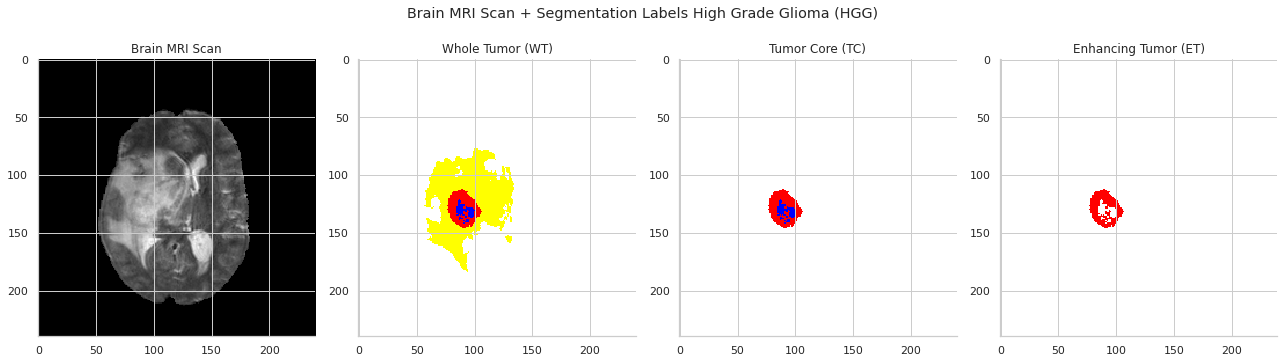

In [ ]:
brain_mri_tumor_labels_viz(example_hgg_mri_image_path, example_hgg_mri_image_seg_mask_path, "High Grade Glioma (HGG)", 75)

Tumor Sub-region labels: [0 1 2]


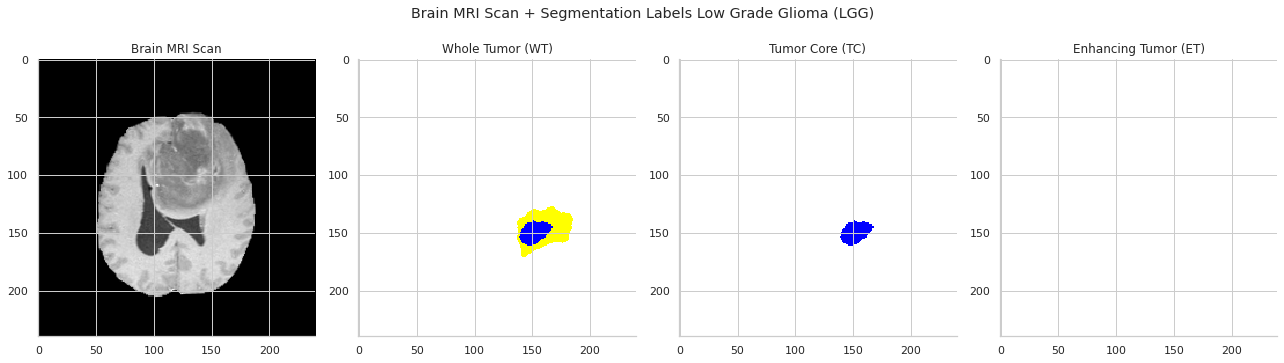

In [ ]:
brain_mri_tumor_labels_viz(example_lgg_mri_image_path, example_lgg_mri_image_seg_mask_path, "Low Grade Glioma (LGG)", 90)

In [ ]:
train_data_transform_func_list = [LoadImaged(keys = ["image", "seg_mask"]),
                                  EnsureChannelFirstd(keys = ["image"]),
                                  EnsureTyped(keys = "seg_mask", 
                                              dtype = np.int8),
                                  Lambdad(keys = "seg_mask", 
                                          func = extract_tumor_labels_from_seg_masks),
                                  Spacingd(keys = ["image", "seg_mask"], 
                                           pixdim = (1.0, 1.0, 1.0), 
                                           mode = ("area", "area")),
                                  Orientationd(keys = ["image", "seg_mask"], 
                                               axcodes = "RAS"),
                                  AdjustContrastd(keys = "image", gamma = 1.5),
                                  NormalizeIntensityd(keys = ["image"],
                                                      nonzero = True, 
                                                      channel_wise = True),
                                  # HistogramNormalized(keys = "image"),
                                  RandScaleIntensityd(keys = ["image"], 
                                                      factors = (0, 10),
                                                      prob = 0.3),
                                  RandStdShiftIntensityd(keys = "image", 
                                                         factors = 0.1,
                                                         nonzero = True,
                                                         channel_wise = True,
                                                         prob = 0.7),
                                  RandFlipd(keys = ["image", "seg_mask"], 
                                            prob = 0.7, 
                                            spatial_axis = (0, 1)),
                                  RandZoomd(keys = ["image", "seg_mask"], 
                                            prob = 0.8),
                                  RandGaussianSharpend(keys = "image", 
                                                       prob = 0.3),
                                  RandGaussianNoised(keys = "image", 
                                                     prob = 0.8, 
                                                     mean = 0, 
                                                     std = np.random.uniform(0, 0.45)),
                                  RandGibbsNoised(keys = "image", 
                                                 prob = 0.5),
                                  EnsureTyped(keys = "image",
                                              device = device, 
                                              dtype = np.float32),
                                  EnsureTyped(keys = "seg_mask", 
                                              device = device, 
                                              dtype = np.int8)
                                ]

In [ ]:
training_data = Dataset(train_data_files, transform = Compose(train_data_transform_func_list))
training_data_loader = DataLoader(training_data, 
                                  batch_size = 1, 
                                  shuffle = True, 
                                  num_workers = 2, 
                                  pin_memory = torch.cuda.is_available())

In [ ]:
def brain_mri_img_seg_viz(sample_data: monai.data.Dataset, plot_title: str, tumor_label: int = tumor_label_id["WT"]) -> None:
    glioma_grades = [training_data_seg_masks_df.loc[training_data_seg_masks_df.image_path == curr_data["seg_mask_meta_dict"]["filename_or_obj"].strip(), "tumor_class"].to_list()[0] for curr_data in sample_data]
    fig, axes = plt.subplots(nrows = len(sample_data), ncols = 5, figsize = (25, 10))
    fig.suptitle(plot_title, y = 1.03, fontdict = dict(size = 16))
    for row_idx, curr_train_data in enumerate(sample_data):
        curr_img, curr_seg_img = curr_train_data["image"].cpu().numpy(), curr_train_data["seg_mask"].cpu().numpy().copy().astype(np.float32)
        # curr_seg_img[curr_seg_img == 0.0] = np.nan
        for col_idx in range(5):
            if col_idx != 4:
                axes[row_idx, col_idx].imshow(curr_img[col_idx, :, :, 100], cmap = "gray", interpolation = "antialiased")
                axes[row_idx, col_idx].axis("off")
                axes[row_idx, col_idx].set_title("-".join(os.path.split(curr_train_data["image_meta_dict"]["filename_or_obj"])[-1].split("_")[:-1]), fontdict = dict(size = 12))
                continue
            axes[row_idx, col_idx].imshow(curr_seg_img[tumor_label, :, :, 100], 
                                          cmap = hgg_cmap if glioma_grades[row_idx] == "HGG" else lgg_cmap, 
                                          norm = hgg_norm if glioma_grades[row_idx] == "HGG" else lgg_norm, 
                                          interpolation = "antialiased")
            # axes[row_idx, col_idx].axis("off")
            axes[row_idx, col_idx].set_title(f"Segmentation Mask", fontdict = dict(size = 12))
    sns.despine()
    fig.tight_layout()

In [ ]:
print(f"Segmentaion Mask Labels for BraTS20-Training-345: {np.unique(training_data[0]['seg_mask'].cpu().numpy())}")
print(f"Segmentation Mask Labels for BraTS20-Training-193: {np.unique(training_data[1]['seg_mask'].cpu().numpy())}")

Segmentaion Mask Labels for BraTS20-Training-345: [0 1 2 3 4]
Segmentation Mask Labels for BraTS20-Training-193: [0 1 2 4]


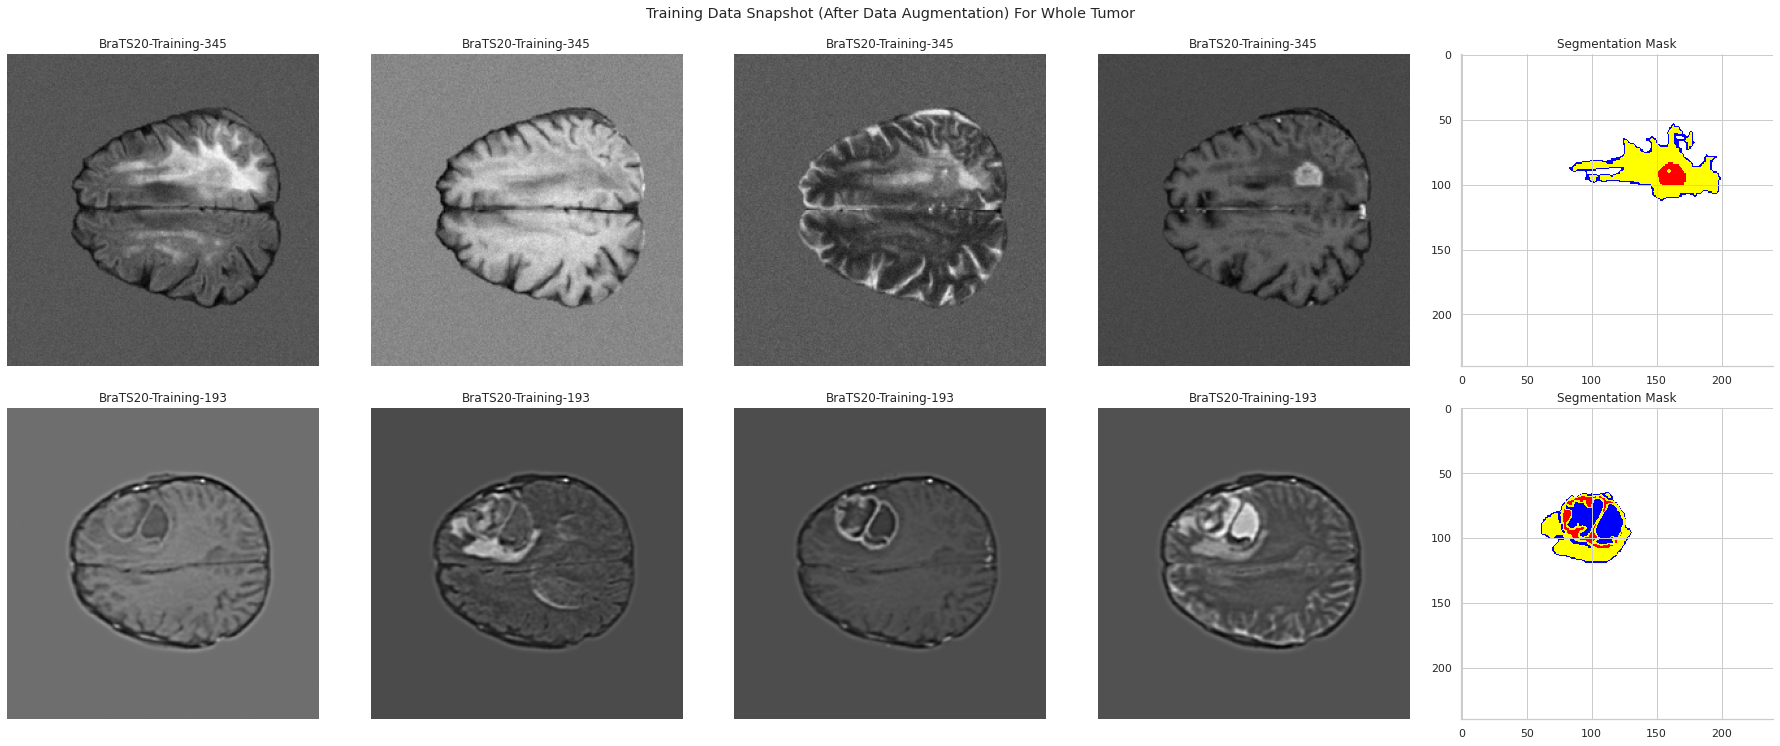

In [ ]:
brain_mri_img_seg_viz(training_data[:2], 
                      "Training Data Snapshot (After Data Augmentation) For Whole Tumor")

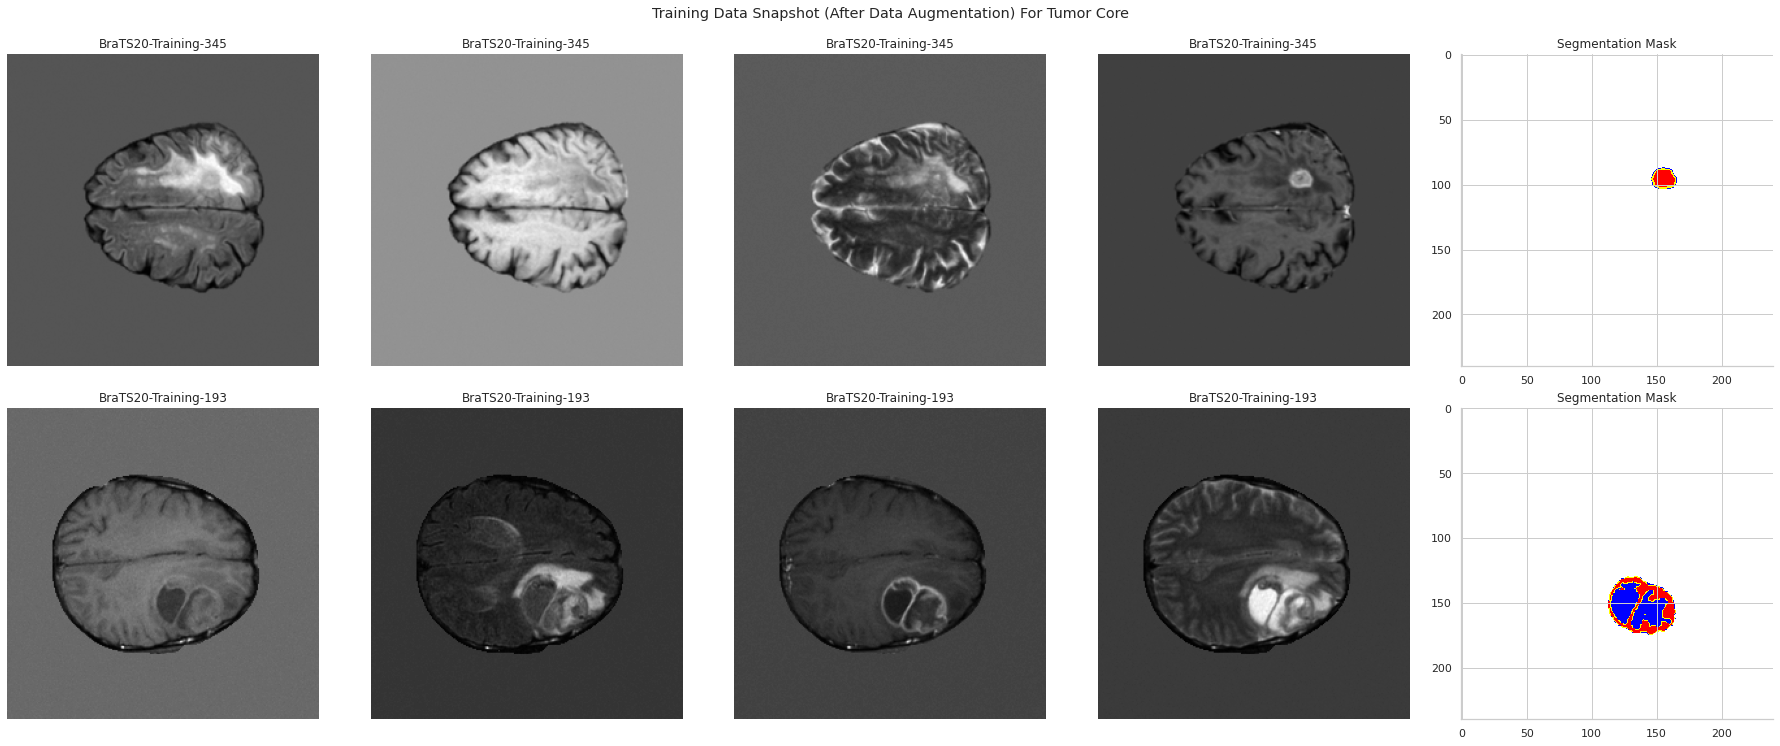

In [ ]:
brain_mri_img_seg_viz(training_data[:2], 
                      plot_title = "Training Data Snapshot (After Data Augmentation) For Tumor Core", 
                      tumor_label = tumor_label_id["TC"])

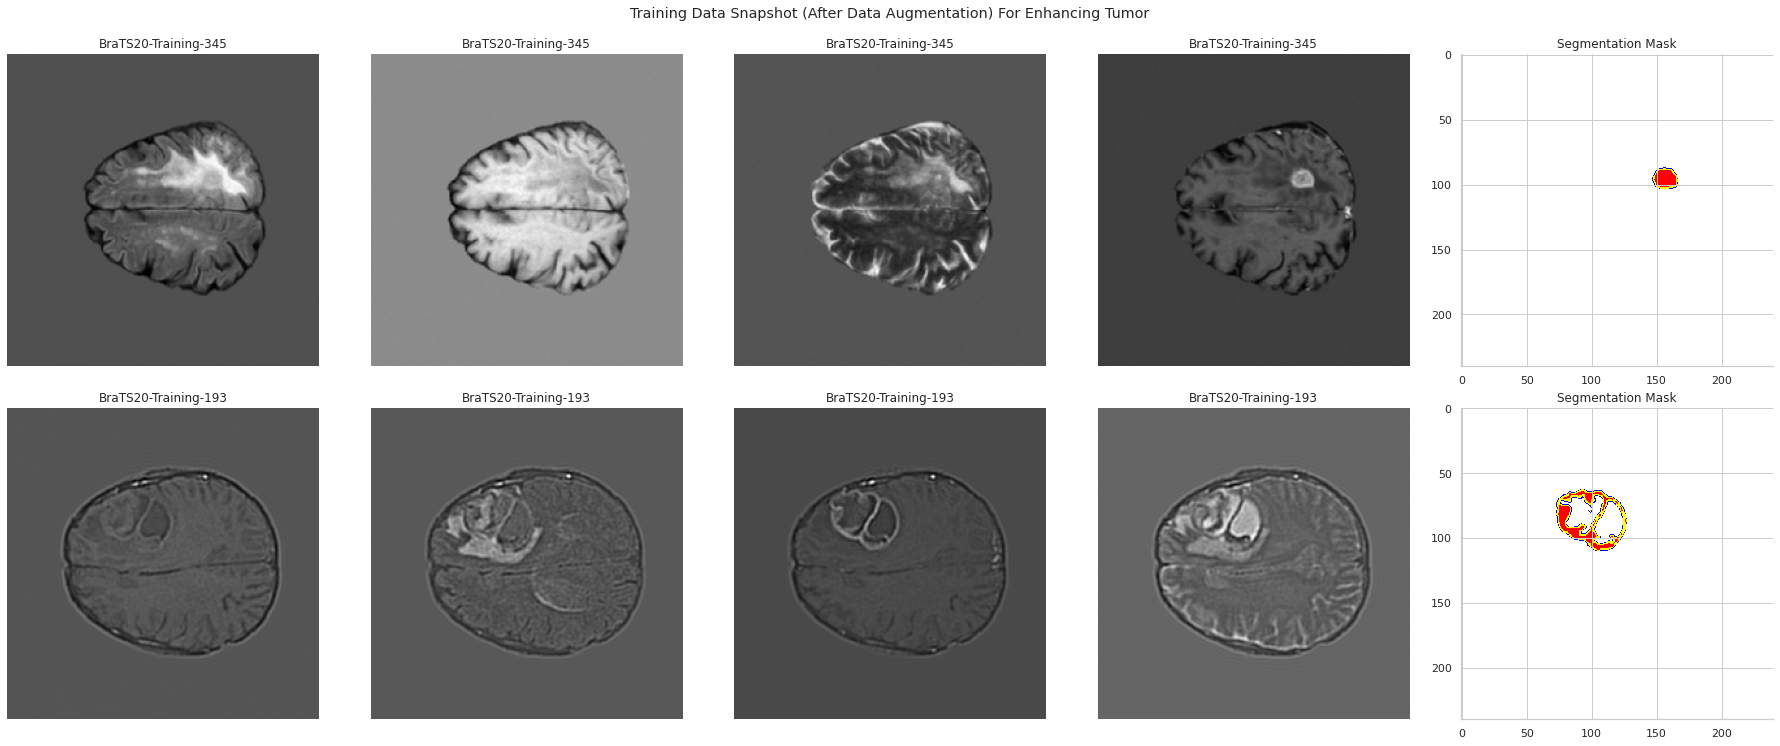

In [ ]:
brain_mri_img_seg_viz(training_data[:2], 
                      plot_title = "Training Data Snapshot (After Data Augmentation) For Enhancing Tumor", 
                      tumor_label = tumor_label_id["ET"])

In [ ]:
validation_data_transform_func_list = [LoadImaged(keys = ["image", "seg_mask"]),
                                       EnsureChannelFirstd(keys = "image"),
                                       EnsureTyped(keys = "seg_mask", 
                                                   dtype = np.int8),
                                       Lambdad(keys = "seg_mask", 
                                               func = extract_tumor_labels_from_seg_masks),
                                       Spacingd(keys = ["image", "seg_mask"], 
                                                pixdim = (1.0, 1.0, 1.0), 
                                                mode = ("area", "area")),
                                       Orientationd(keys = ["image", "seg_mask"], 
                                                    axcodes = "RAS"),
                                       NormalizeIntensityd(keys = ["image"], 
                                                           nonzero = True, 
                                                           channel_wise = True),
                                       RandStdShiftIntensityd(keys = ["image"], 
                                                              nonzero = True,
                                                              channel_wise = True, 
                                                              factors = (0, 10), 
                                                              prob = 0.5),  
                                       RandFlipd(keys = ["image", "seg_mask"], 
                                                 spatial_axis = (0, 1), 
                                                 prob = 0.5),
                                       RandGaussianNoised(keys = "image", 
                                                          mean = 0, 
                                                          std = np.random.uniform(0, 0.45), 
                                                          prob = 0.8),
                                       EnsureTyped(keys = "image", 
                                                   device = device,
                                                   dtype = np.float32),
                                       EnsureTyped(keys = "seg_mask", 
                                                   device = device, 
                                                   dtype = np.int8)
                                    ]

In [ ]:
validation_data = Dataset(val_data_files, transform = Compose(validation_data_transform_func_list))
validation_data_loader = DataLoader(validation_data, 
                                    batch_size = 1, 
                                    shuffle = True, 
                                    num_workers = 2,
                                    pin_memory = torch.cuda.is_available())

In [ ]:
print(f"Segmentation Mask Labels for BraTS-Training-120 image: {np.unique(validation_data[7]['seg_mask'].cpu().numpy())}")
print(f"Segmentation Mask Labels for BraTS-Training-306 image: {np.unique(validation_data[8]['seg_mask'].cpu().numpy())}")

Segmentation Mask Labels for BraTS-Training-120 image: [0 1 2 4]
Segmentation Mask Labels for BraTS-Training-306 image: [0 1 2]


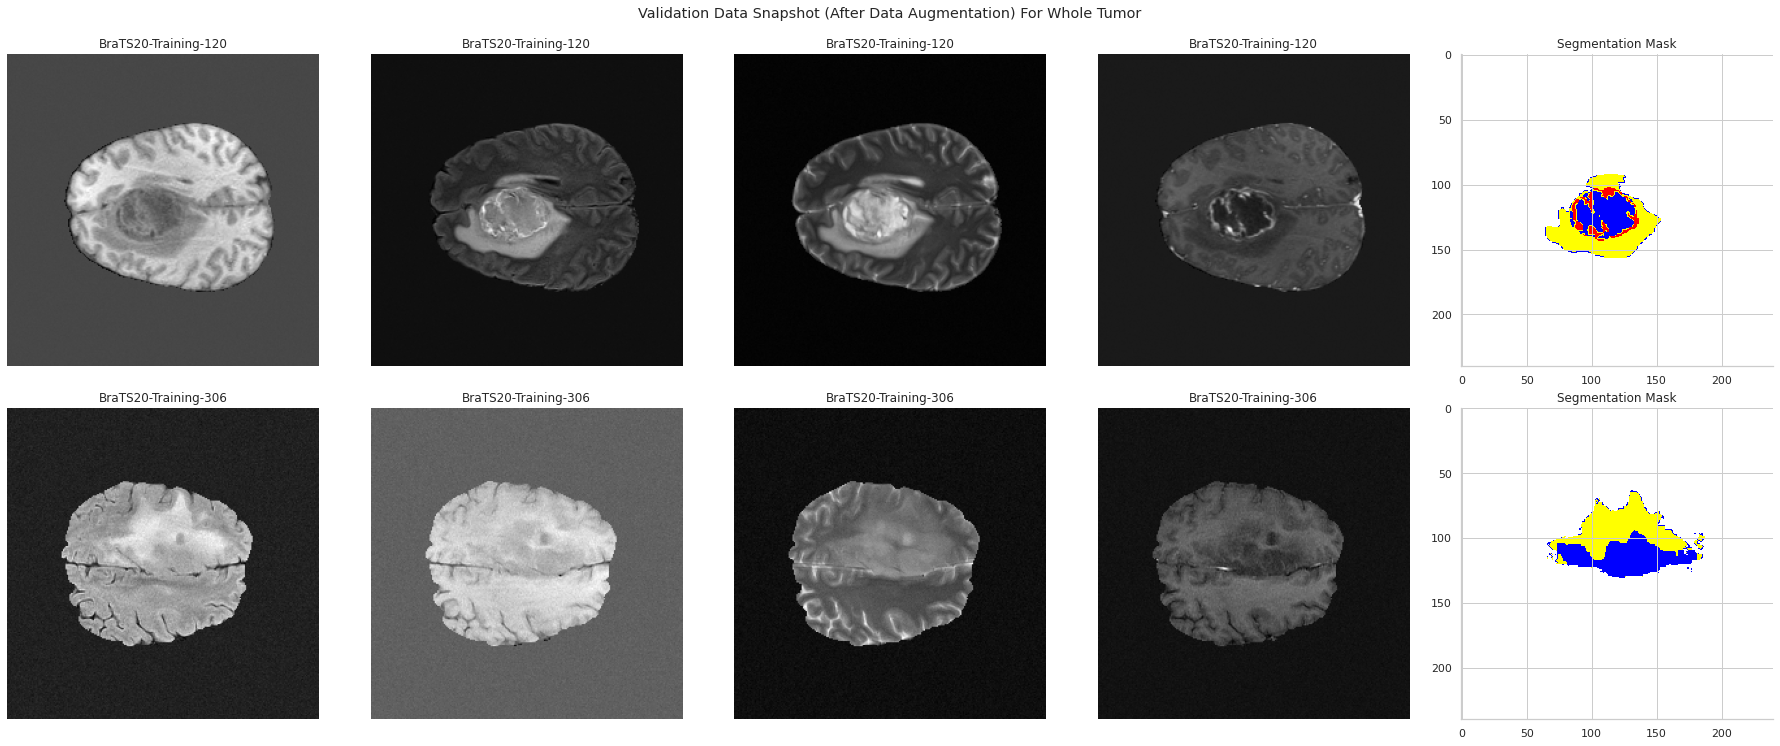

In [ ]:
brain_mri_img_seg_viz(validation_data[7:9], plot_title = "Validation Data Snapshot (After Data Augmentation) For Whole Tumor")

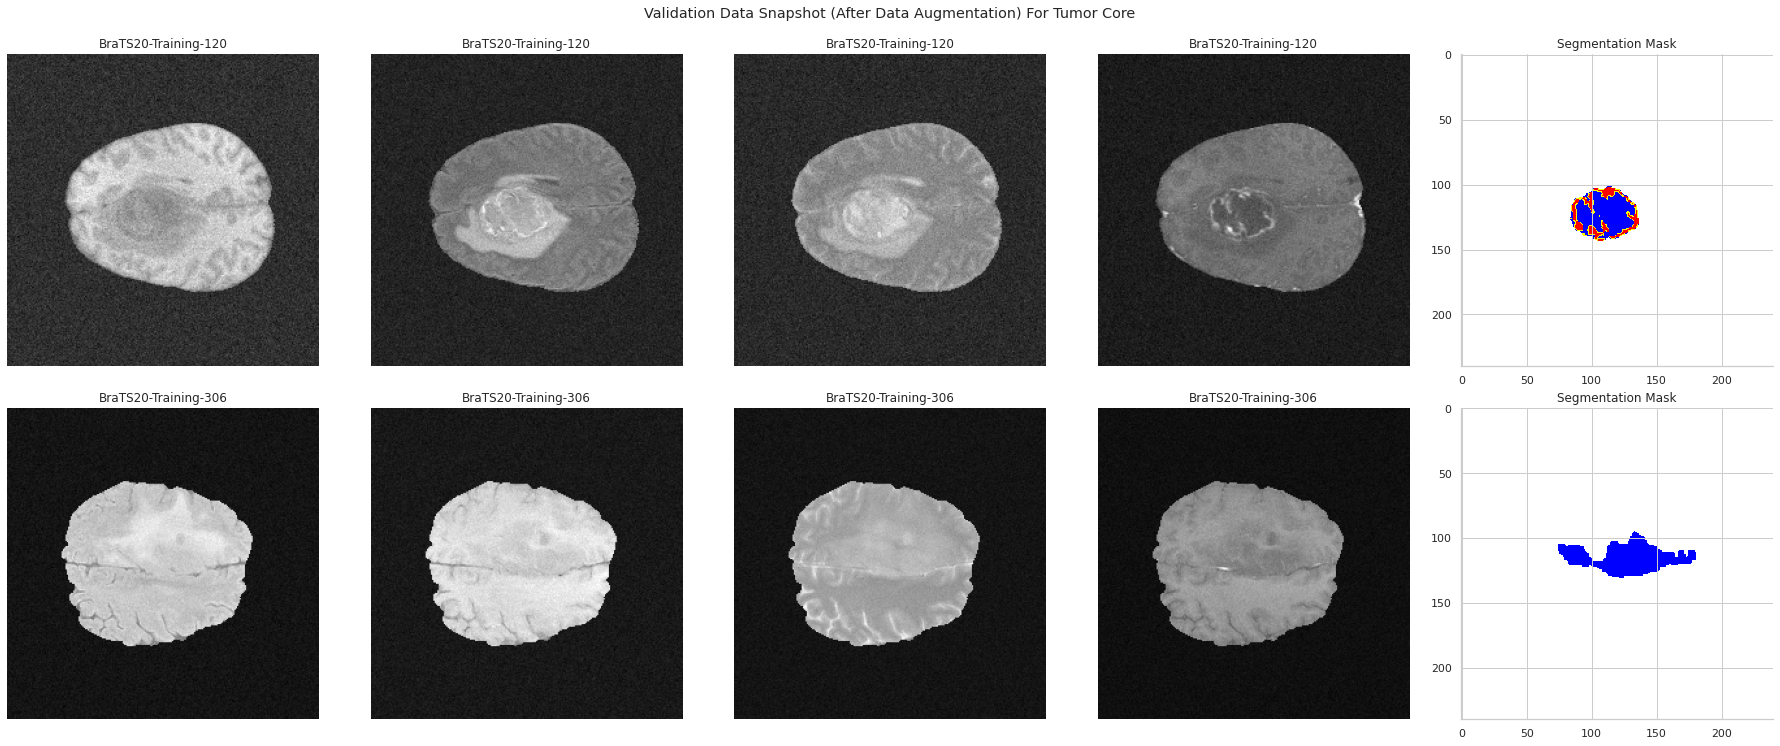

In [ ]:
brain_mri_img_seg_viz(validation_data[7:9], 
                      plot_title = "Validation Data Snapshot (After Data Augmentation) For Tumor Core", 
                      tumor_label = tumor_label_id["TC"])

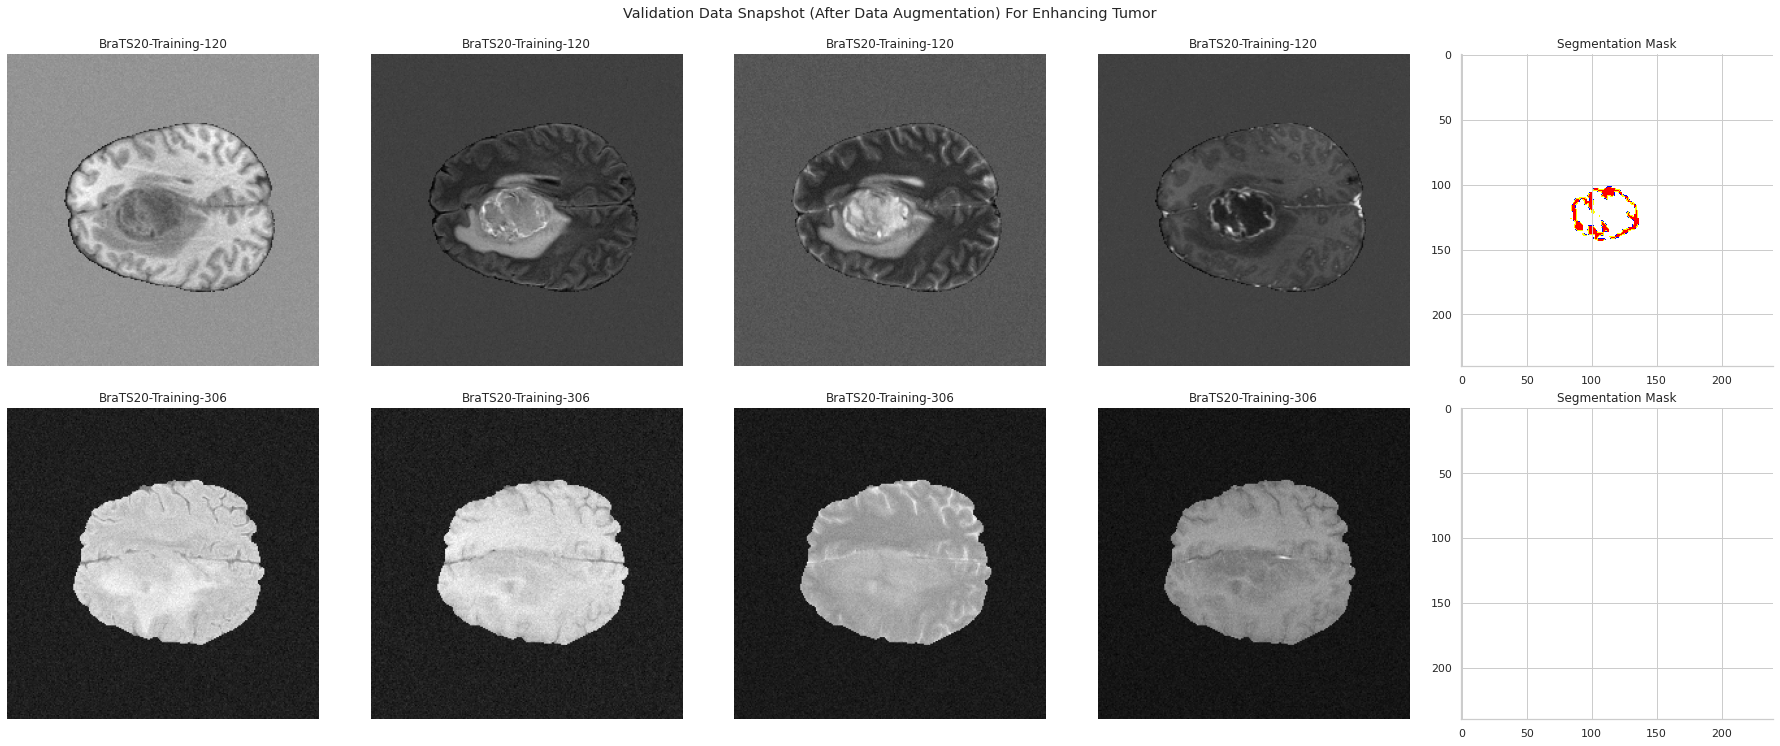

In [ ]:
brain_mri_img_seg_viz(validation_data[7:9], 
                      plot_title = "Validation Data Snapshot (After Data Augmentation) For Enhancing Tumor", 
                      tumor_label = tumor_label_id["ET"])

In [ ]:
testing_data = Dataset(testing_data_dicts)
testing_data_loader = DataLoader(testing_data, 
                                 batch_size = 1, 
                                 shuffle = True, 
                                 num_workers = 2, 
                                 pin_memory = torch.cuda.is_available())